# Train a simple image classification model on playing card images using PyTorch

Main steps for achieving that goal:
1. Create Pytorch Dataset class to load images from folders
2. Create a simple CNN model using a pre-trained EfficientNet backbone
3. Pytorch training loop with validation
4. Evaluation and visualization of results
5. Saving the model for future use

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

import warnings
warnings.filterwarnings("ignore", message="Using the native apex kernel for RoPE.")
import mercury as mr
 
# configure App properties
app = mr.App(title="Static notebook", description="Display static notebook", static_notebook=True)

/opt/venv/lib/python3.12/site-packages/apex/transformer/functional/fused_rope.py:54: UserWarning: Using the native apex kernel for RoPE.
  warnings.warn("Using the native apex kernel for RoPE.", UserWarning)


System Version: 3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]
PyTorch version 2.9.1+rocm7.1.1.git351ff442
Torchvision version 0.24.0+rocm7.1.1.gitb919bd0c
Numpy version 2.3.5
Pandas version 2.3.3


mercury.App

## Step 1. Create Pytorch Dataset and Dataloader
For creating a dataset, we can use the `ImageFolder` class from `torchvision.datasets` which assumes that images are organized in folders where each folder name is the class label. But in this specific case we already split the dataset into train, valid, and test folders.  
An example for the used folder structure would be:
./data/train/ace of spades/001.jpg

<sup>(The dataset can be found here: [https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification]("https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification"))</sup>

In [4]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

### Dataloader  

Loading and batching our dataset:  
We do that because it's way faster to train a model in batches (bulk of images) instead of giving it one picture of a time.

In [6]:
dataset = PlayingCardDataset('/workspace/JMetzProjects/image_classification/playing_cards/data/train')

In [7]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## Step 2. Create a PyTorch Model
Pytorch datasets follow a specific structure (similar to dataset structure).  
Now you could create a simple CNN model from scratch, but it's often better to use a pre-trained model as a backbone and add a custom classifier on top of it. Also, we modify the last to correspond to the number of classes in our dataset (53 playing cards).  
Those pretrained models are available in the `timm` library for example.

In [8]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [9]:
model = SimpleCardClassifer(num_classes=53)
print(str(model)[:500])

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


## Step 3. The Training Loop

After setting up the dataset and model, we can define the loss function and optimizer, and create a training loop.

Some important points to consider:

- We want to validate our model by testing it on new data it hasn't seen during training (validation set)
- For faster training, we want to use GPU if available
- Important terms:
  - **Epoch**: One full pass through the training dataset
  - **Step**: One batch of data passed through the model

The training loop will consist of two main phases: **training** and **validation**.

Two things to select for a model:

- **Loss function**: `CrossEntropyLoss` for multi-class classification (what the model will optimize for)
- **Optimizer**: `Adam` optimizer (Allrounder, good for most basic tasks)

Another very important step is visualizing the training and validation losses over epochs to monitor the model's performance and check for overfitting (model memorizes train data instead of generalizing).

In [11]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Setup Datasets and Dataloaders

In [13]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/workspace/JMetzProjects/image_classification/playing_cards/data/train'
valid_folder = '/workspace/JMetzProjects/image_classification/playing_cards/data/valid'
test_folder = '/workspace/JMetzProjects/image_classification/playing_cards/data/test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Specify GPU if available
print("Using device:", device)

Using device: cuda


### Training Loop

In [15]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5508645407675696, Validation loss: 0.4370774685211901


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5472054099361143, Validation loss: 0.2462155483803659


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.34644719735491564, Validation loss: 0.12413581232979612


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.24447629865012666, Validation loss: 0.1341334561694343


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.17639847905037911, Validation loss: 0.17153890582750428


### Visualize Losses

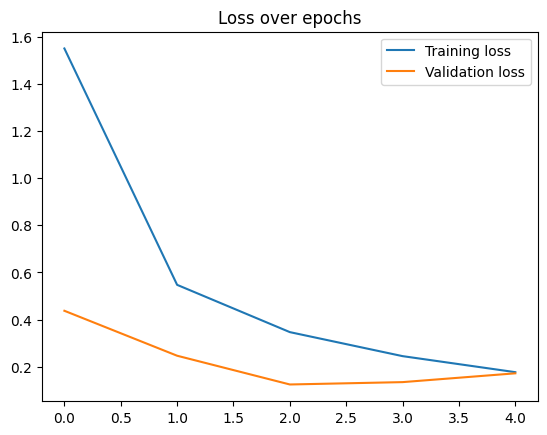

In [16]:
# Visualize  
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Step 4. Evaluation and Visualization of Results

### Evaluation on test image from Google Search

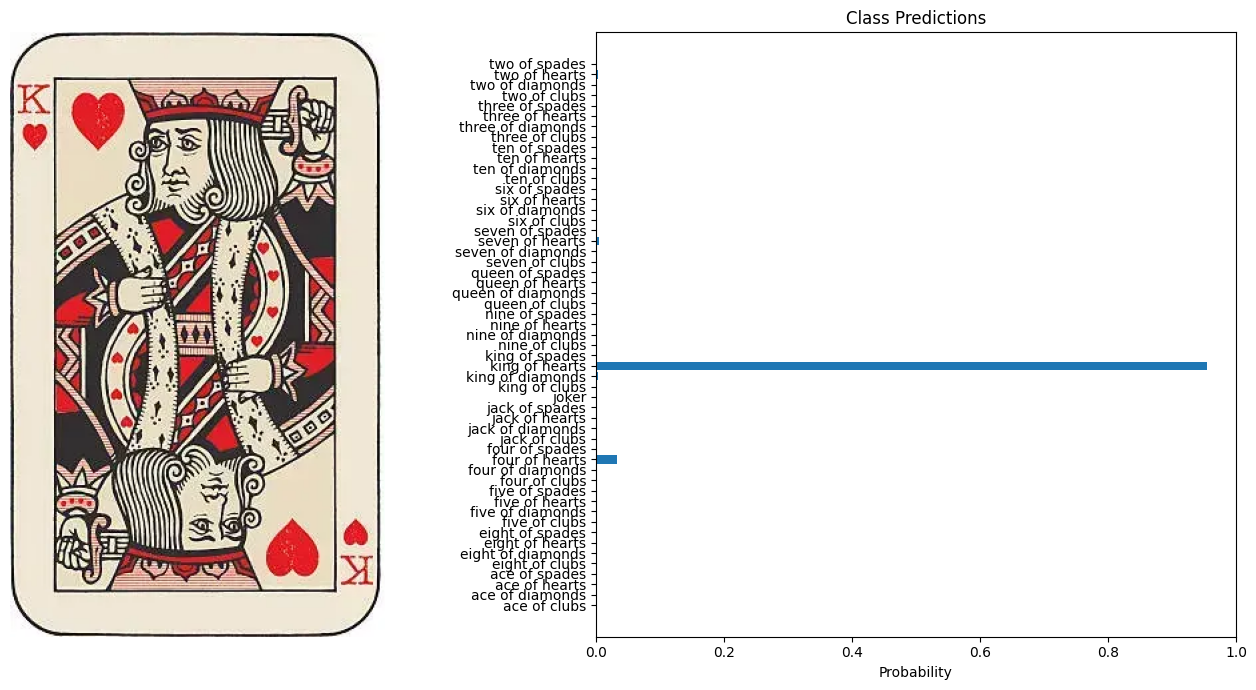

In [17]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/workspace/JMetzProjects/image_classification/playing_cards/king_of_hearts.webp"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

### Evaluation on 10 random images from test dataset

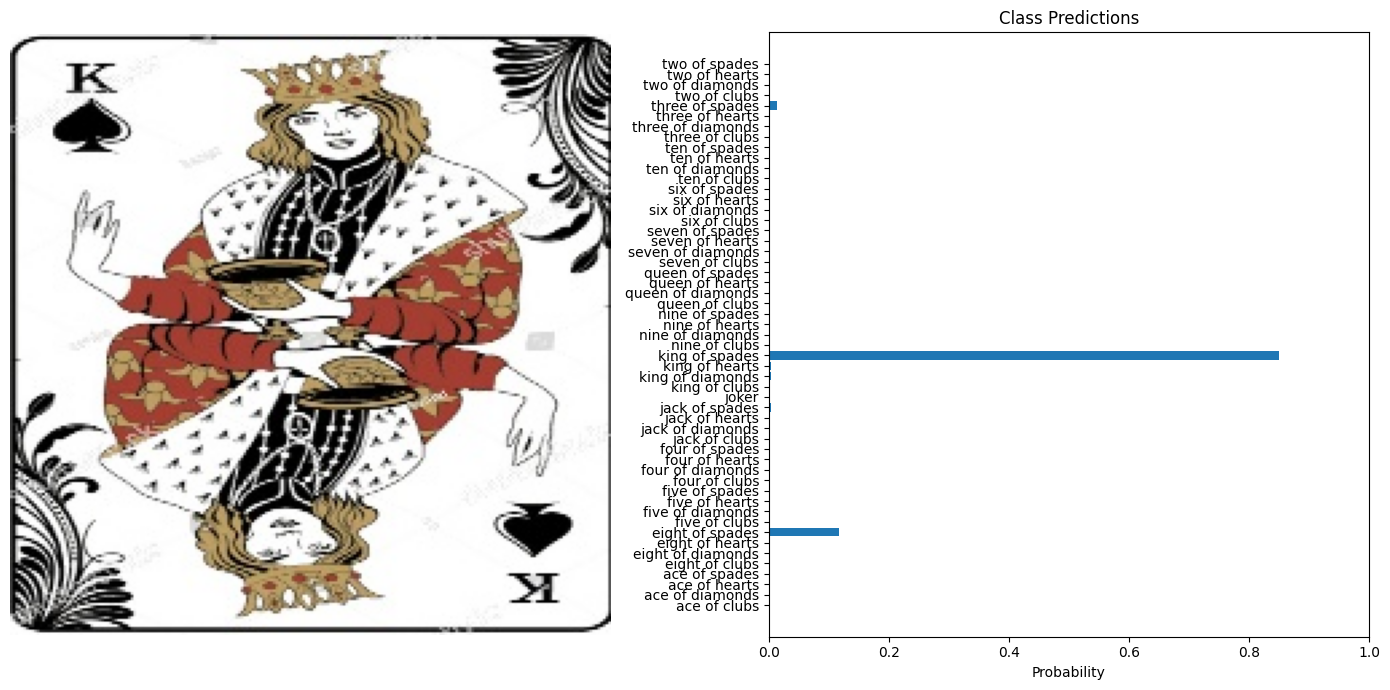

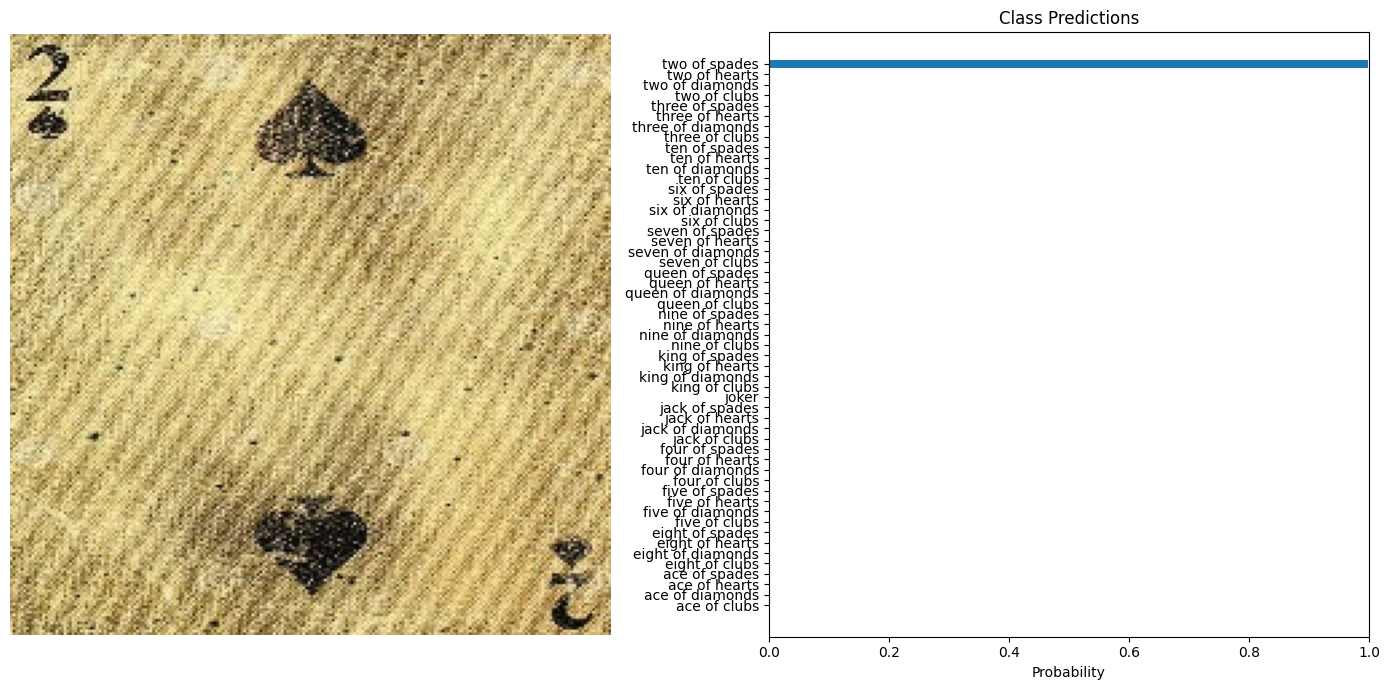

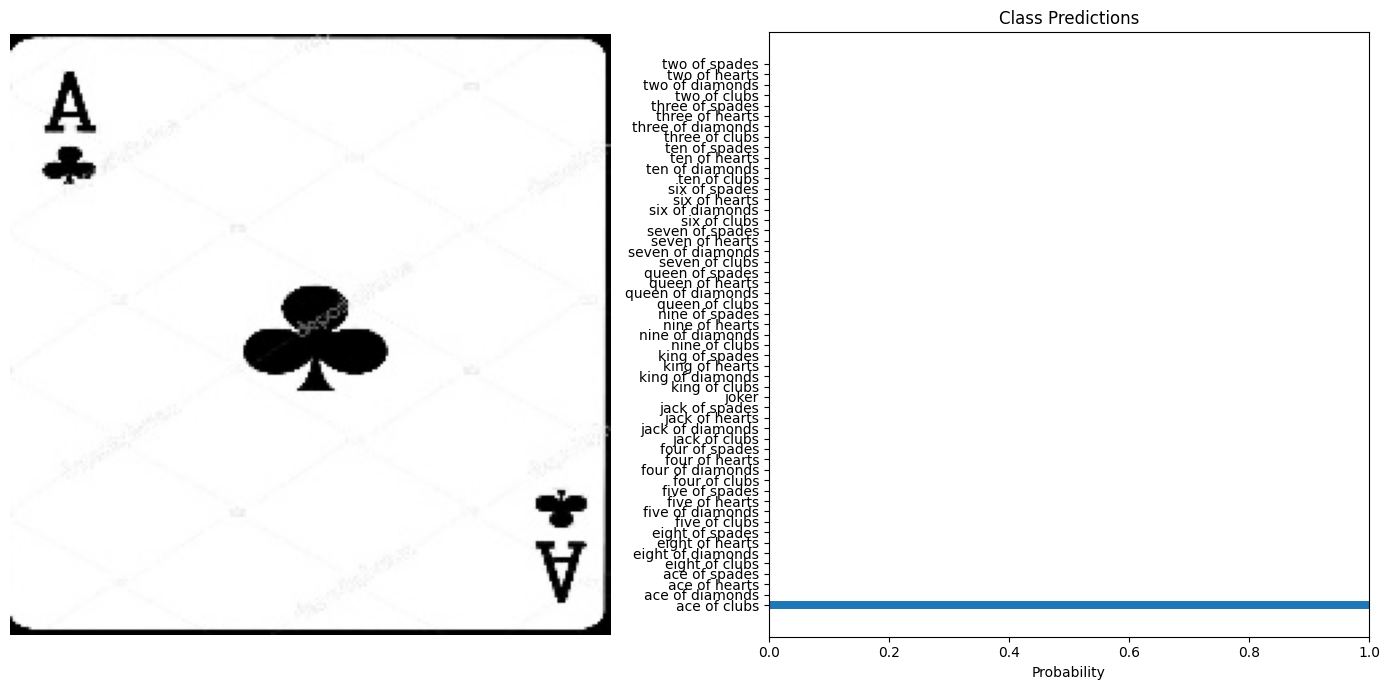

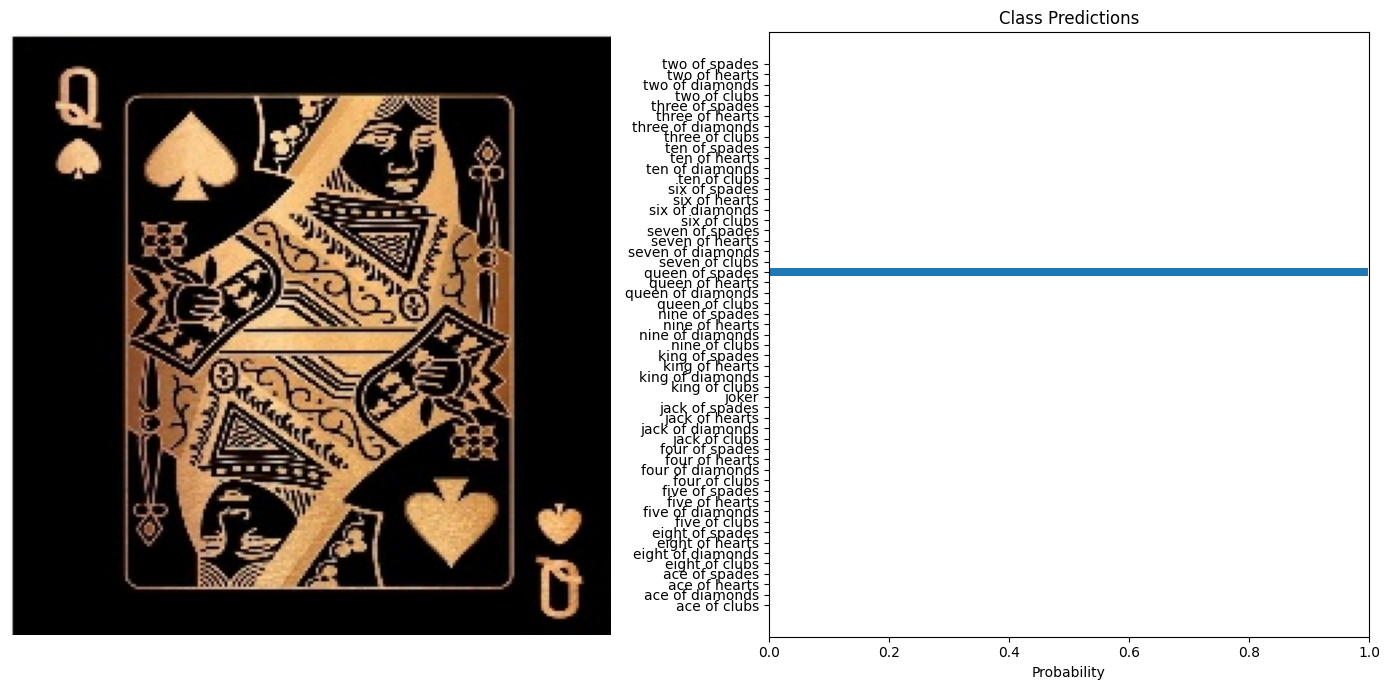

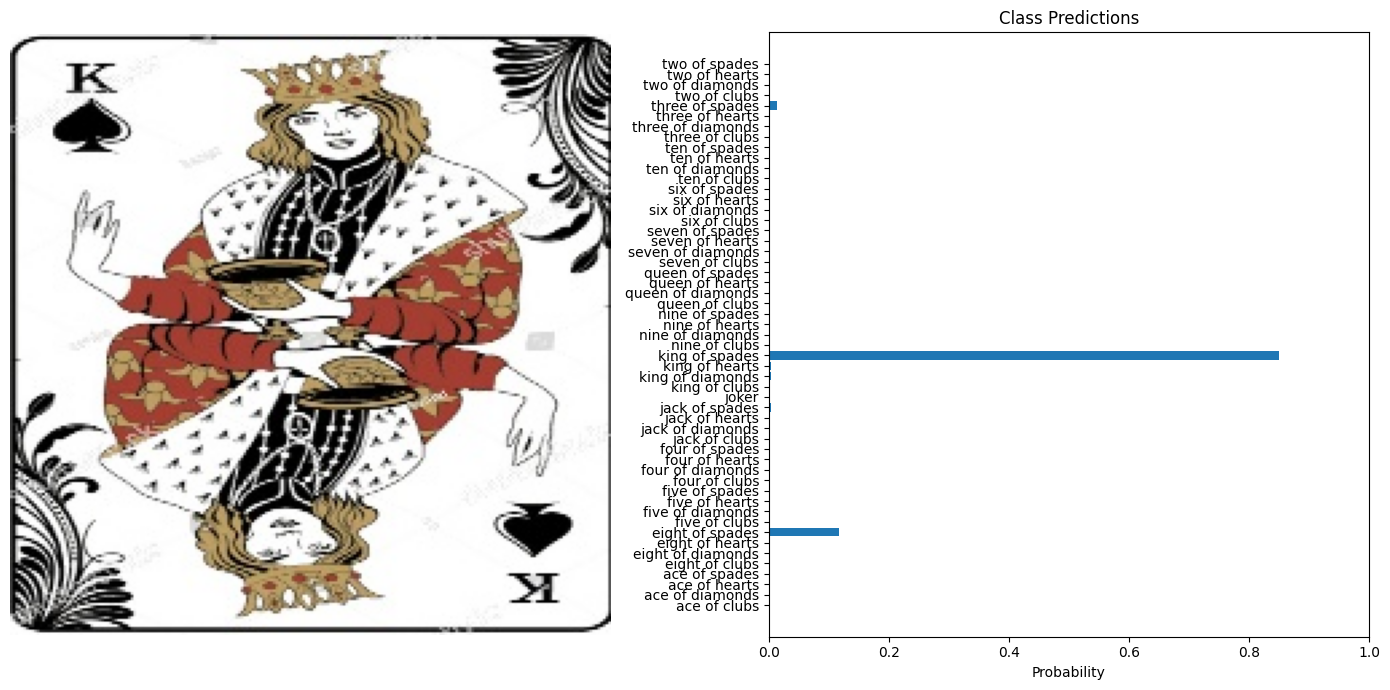

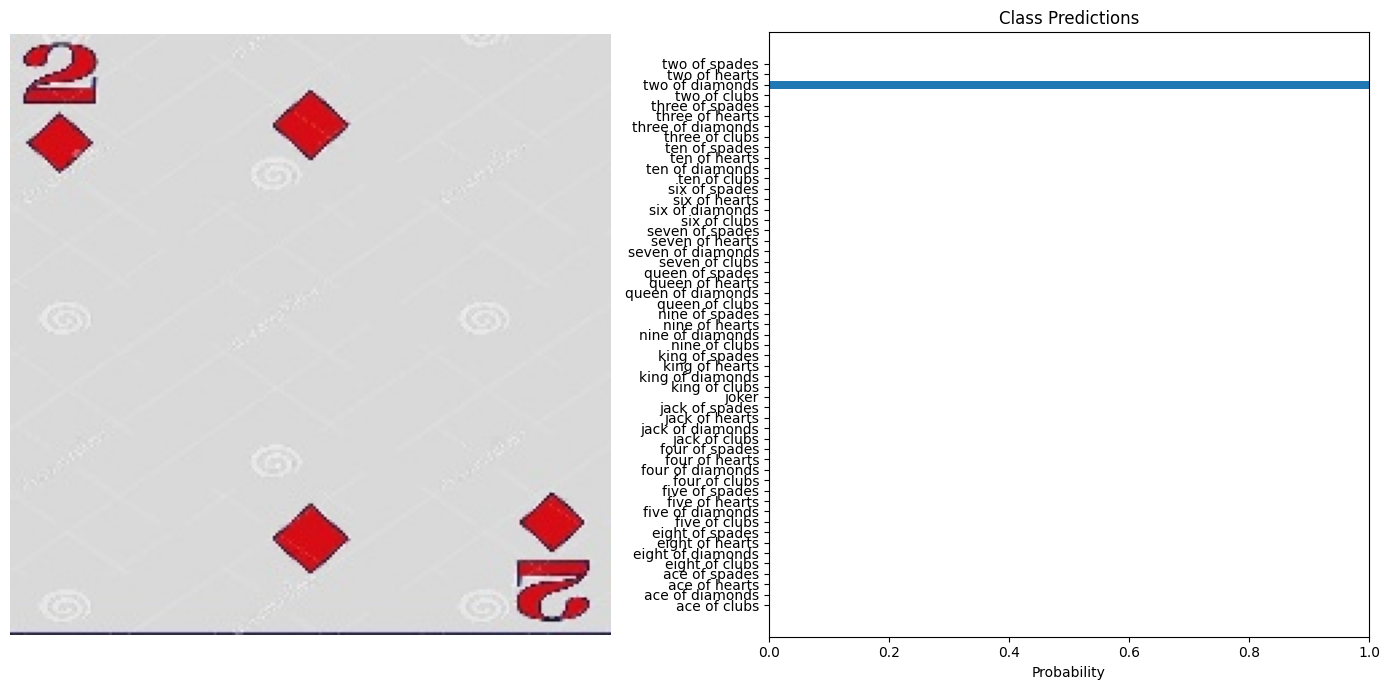

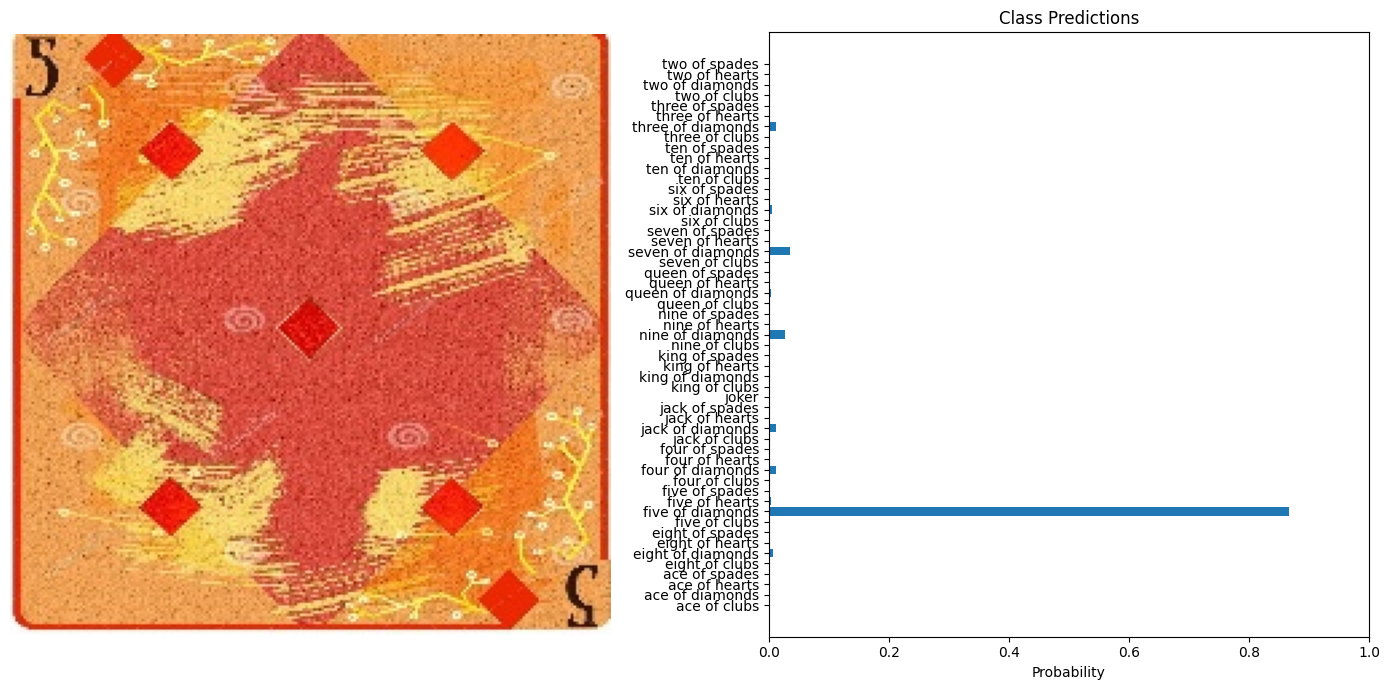

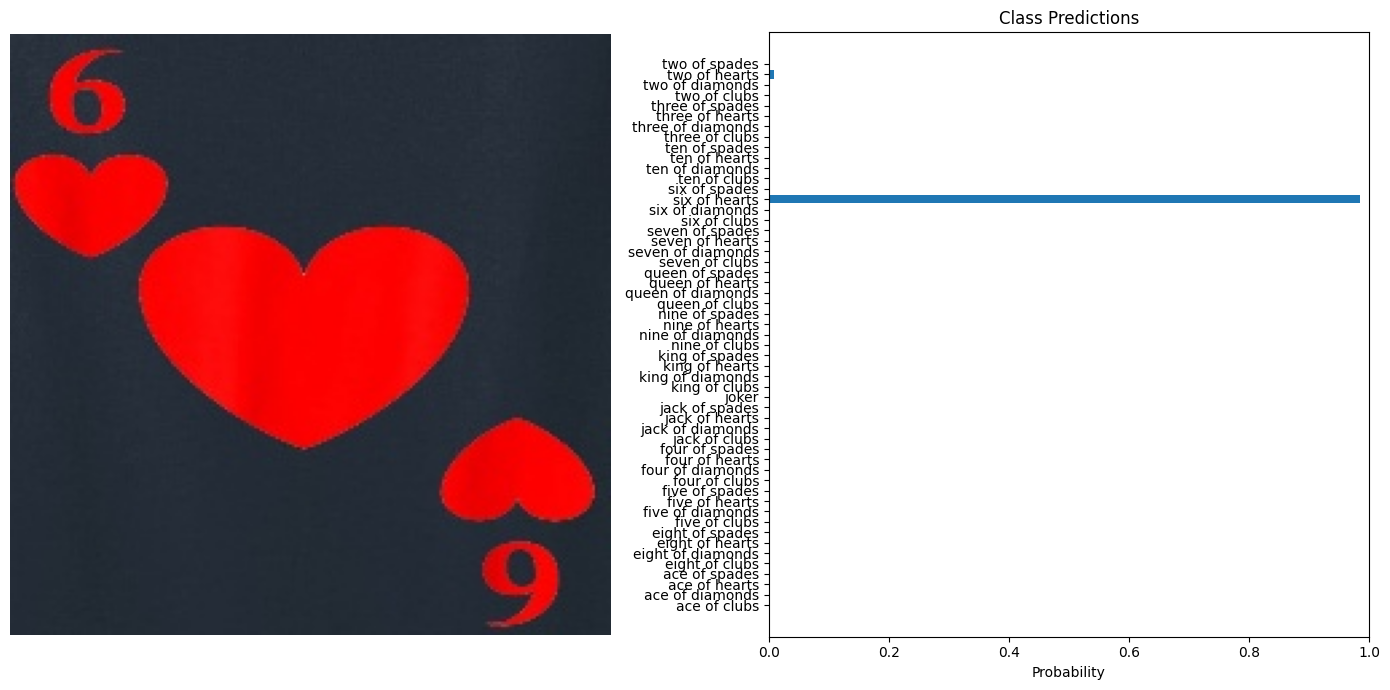

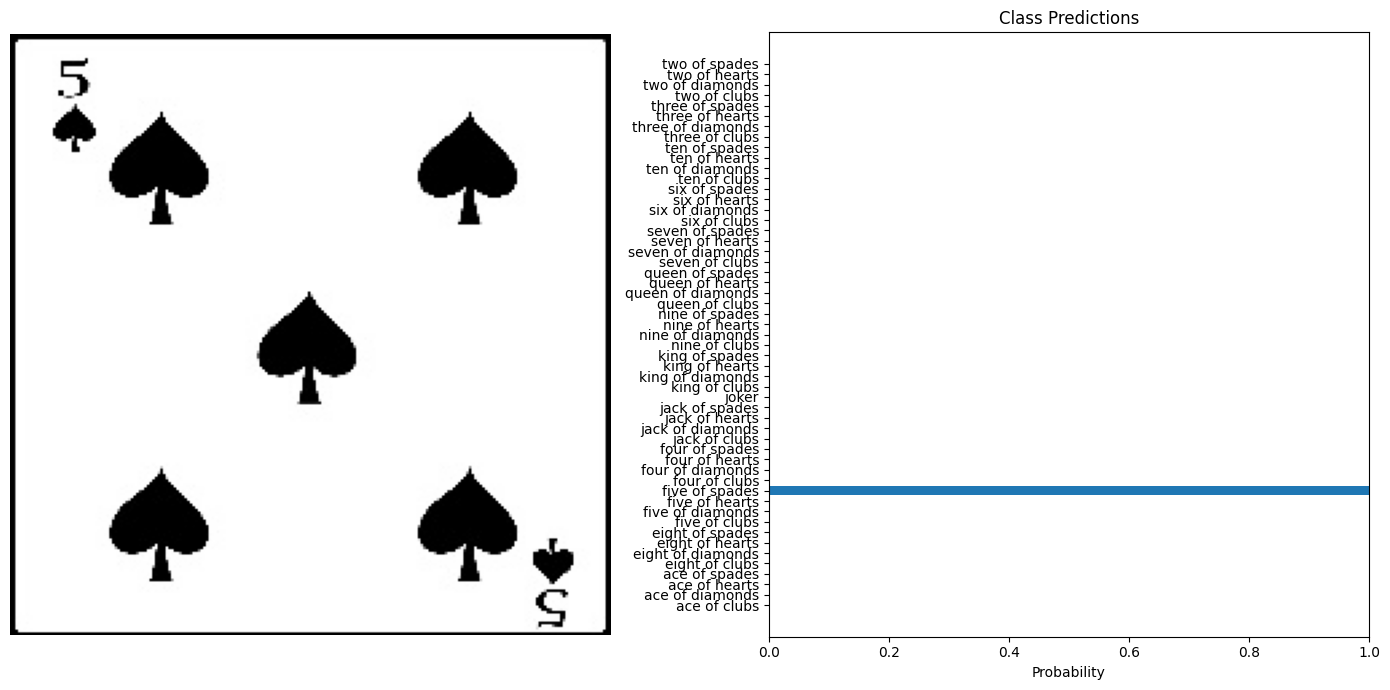

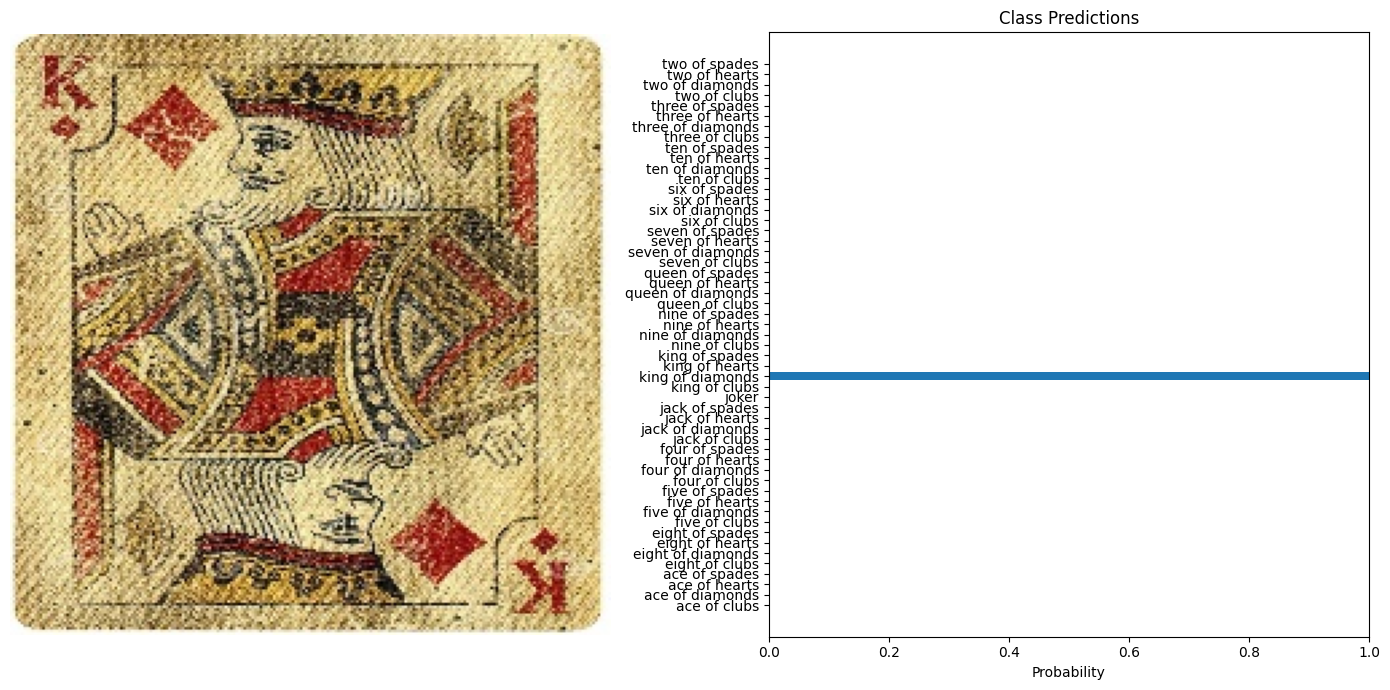

In [18]:
from glob import glob
test_images = glob('/workspace/JMetzProjects/image_classification/playing_cards/data/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

## Step 5. Saving the Model for Future Use

In [20]:
torch.save(model.state_dict(), "/workspace/JMetzProjects/image_classification/playing_cards/model.pth")